# 103. Exo : identification from photos

## 1. Importing libraries

In [1]:
# ONLY WITH SCIKIT-LEARN
# Import all the tools we need 

# Regular EDA and ploting libraries 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from tqdm import tqdm

%matplotlib inline 
#Cause we want our plots to appear in the notebook

# Models from scikit-learn 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier


# Model evaluation 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve
from sklearn.inspection import permutation_importance
from tqdm import tqdm

# The sklearn dataset module
from sklearn import datasets

# We deactivate the warnings
import warnings
warnings.filterwarnings('ignore')       


## 2. Loading and formatting data

In [2]:
# Recommended Tutorials to follow
# https://www.programcreek.com/python/example/104694/sklearn.datasets.fetch_olivetti_faces
# https://gist.github.com/mick001/e22582b1d67e02396dcbd199d60d117e
# https://www.educative.io/answers/what-is-sklearndatasetsfetcholivettifaces-in-python

# Load OLIVETTI data (included in SK-LEARN)
fetch_olivetti_faces = datasets.fetch_olivetti_faces(
   data_home=None,
   shuffle=False,
   random_state=0,
   download_if_missing=True,
   return_X_y=False
)

target  = fetch_olivetti_faces.target
data   = fetch_olivetti_faces.data
images = fetch_olivetti_faces.images
classes = np.unique(target)
classes.sort()

# We inspect the dimensions of the labels 
print('Label dimensions:\n', np.shape(target), '\n')

# We inspect the dimensions of the data 
print('Dimension of the data:\n', np.shape(data), '\n')

# We inspect the dimensions of the images
print('Dimension of the images:\n', np.shape(images), '\n')

# We inspect the targets of the classes 
print('Values of the classes:\n', classes, '\n')

Label dimensions:
 (400,) 

Dimension of the data:
 (400, 4096) 

Dimension of the images:
 (400, 64, 64) 

Values of the classes:
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39] 



## 3. Visualization of the dataset 

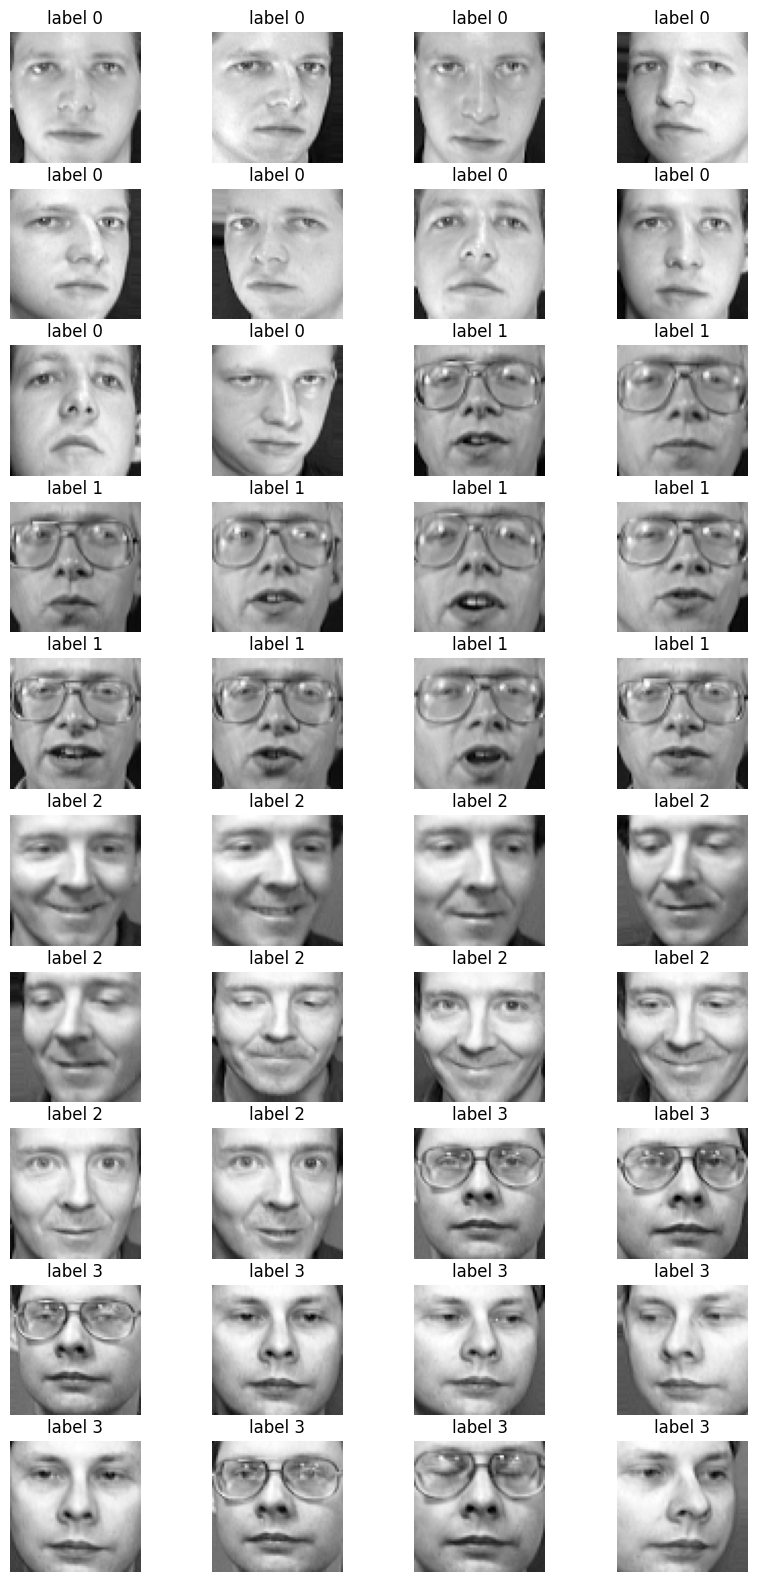

In [3]:
# etc...

# To check RGB Images for dim
def is_colored(image):
    # https://www.programiz.com/python-programming/methods/built-in/all 
    # Check for three channels
    if len(image.shape) == 3:
        R, G, B = image[:, : , 0], image[:, :, 1], image[:, :, 2]
        if (R == G).all() and (G == B).all():
            return True
    return False
    
# method to show images as grid
def show_images(images, target, nb_images=40, grid=False, total_cols=4, figsize=(30, 20)):
    """  
    showing images as grid, 
    images : Image dataset
    target : Images labels
    nb_images : Number of images to display
    grid : Boulen indicating whether the figure will be in grid mode or not  
    total_cols : Desired number of columns
    figsize : The dimensions of the figure 
    """
    assert len(images) > 0
    assert isinstance(images[0], np.ndarray)
    # compute number of cols & row  
    total_cols    = min(nb_images, total_cols)
    total_rows    = int(nb_images / total_cols) + (1 if nb_images % total_cols != 0 else 0)
    # Create a grid of subplots.
    fig, axes = plt.subplots(total_rows, total_cols, figsize=figsize)
    # Create list of axes for easy iteration.
    if isinstance(axes, np.ndarray):
        # https://stackoverflow.com/questions/46862861/what-does-axes-flat-in-matplotlib-do
        list_axes = list(axes.flat)
    else:
        list_axes = [axes]
    # it will helps to show total images as grid 
    for label, i in zip(target[:nb_images], range(nb_images)):
        img    = images[i]
        list_axes[i].imshow(img, cmap='gray')
        list_axes[i].grid(grid)
        list_axes[i].set_axis_off()
        list_axes[i].set_title(f'label {label}')

    for i in range(nb_images, len(list_axes)):
        list_axes[i].set_visible(False)


show_images(images, target, figsize=(10, 20))


## 4. Creation of the classifiers (version 1)

##### 4.1 Split data into train and test sets 

In [4]:
# Set up a random seed 
np.random.seed(22)

# Split into train & test
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2)

In [5]:
# Inspecting the dimensions of training data
print('Inspecting the dimensions of training data')
print('X_train:\n', np.shape(X_train), '\n')
print('y_train:\n', np.shape(y_train), '\n')

# Inspecting the dimensions of testing data
print('Inspecting the dimensions of testing data')
print('X_test:\n', np.shape(X_test), '\n')
print('y_test:\n', np.shape(y_test), '\n')

Inspecting the dimensions of training data
X_train:
 (320, 4096) 

y_train:
 (320,) 

Inspecting the dimensions of testing data
X_test:
 (80, 4096) 

y_test:
 (80,) 



##### 4.2 Learning of classifiers (version 1)

In [6]:
# Put models into a dictionary 
models = {'Logistic Regression' : LogisticRegression(),
          'K-Nearest Neighbours Classifier' : KNeighborsClassifier(),
          'Random Forest Classifier' : RandomForestClassifier(),
          'Gaussian Naive Bayes' : GaussianNB(), 
          'Decision Tree Classifier' : DecisionTreeClassifier()}

# Create a function to fit and score models 
def fit_and_score(models, X_train, X_test, y_train, y_test) : 
  """  
  Fits and evaluates given machine learning models, 
  models : A dictionary of Scikit-Learn machine learning models
  X_train : Our training data (no labels)
  X_test : Testing data (no labels)
  y_train : Training labels
  y_test : Test labels
  """
  # Set up random seed 
  np.random.seed(32)

  # Create a dictionary to keep models scores 
  model_scores = {}

  # Loop through the models 
  for name, model in tqdm(models.items()) : 
    # Fit the model to the data 
    model.fit(X_train, y_train)
    # Evaluate the model and append its score to the dicionary 
    model_scores[name] = model.score(X_test, y_test)
  return model_scores

In [7]:
# Let's use the function we've created earlier
models_scores = fit_and_score(models=models, 
                              X_train=X_train, 
                              X_test=X_test, 
                              y_train=y_train, 
                              y_test=y_test)

100%|██████████| 5/5 [00:14<00:00,  2.92s/it]


In [11]:
models_scores

{'Logistic Regression': 0.975,
 'K-Nearest Neighbours Classifier': 0.8125,
 'Random Forest Classifier': 0.8875,
 'Gaussian Naive Bayes': 0.7875,
 'Decision Tree Classifier': 0.5375}

## 5. Visualization of the results obtained (version 1)

In [12]:
# Turn the dictionary into a DataFrame
model_compare = pd.DataFrame(models_scores, index=["accuracy"])
model_compare.head()

,Logistic Regression,K-Nearest Neighbours Classifier,Random Forest Classifier,Gaussian Naive Bayes,Decision Tree Classifier
accuracy,0.975,0.8125,0.8875,0.7875,0.5375


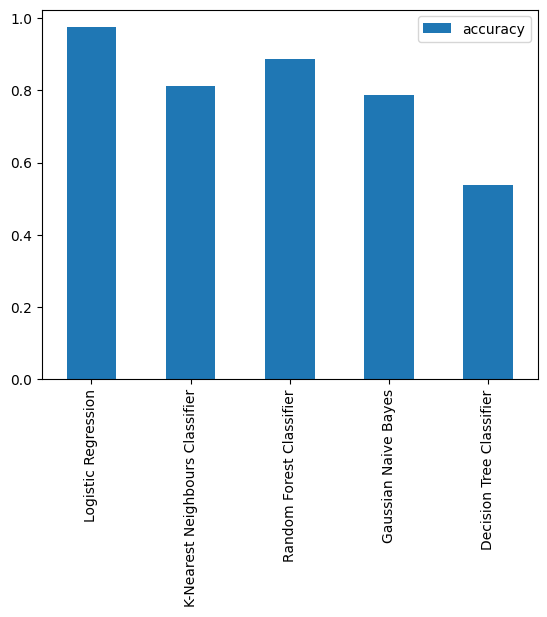

In [13]:
# Recommended Tutorials  
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.bar.html

ax = model_compare.T.plot.bar(stacked=True)
# model_compare.T.plot(kind='bar')

## 6. Creation of the classifier (version 2)

##### 6.1 Learning of classifiers (version 2)

In [14]:
# Recommended Tutorials 
# https://www.kaggle.com/code/enespolat/grid-search-with-logistic-regression
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
# https://stackoverflow.com/questions/19018333/gridsearchcv-on-logisticregression-in-scikit-learn
# https://www.datasklr.com/select-classification-methods/k-nearest-neighbors
# https://medium.com/@erikgreenj/k-neighbors-classifier-with-gridsearchcv-basics-3c445ddeb657#id_token=eyJhbGciOiJSUzI1NiIsImtpZCI6ImNhYWJmNjkwODE5MTYxNmE5MDhhMTM4OTIyMGE5NzViM2MwZmJjYTEiLCJ0eXAiOiJKV1QifQ.eyJpc3MiOiJodHRwczovL2FjY291bnRzLmdvb2dsZS5jb20iLCJuYmYiOjE2NjMyNDkzMzAsImF1ZCI6IjIxNjI5NjAzNTgzNC1rMWs2cWUwNjBzMnRwMmEyamFtNGxqZGNtczAwc3R0Zy5hcHBzLmdvb2dsZXVzZXJjb250ZW50LmNvbSIsInN1YiI6IjExMjA0MDI2NDk2MDY4NTU0OTk2NSIsImVtYWlsIjoiYnJhbmlzZ2hvdWwwMkBob3RtYWlsLmNvbSIsImVtYWlsX3ZlcmlmaWVkIjp0cnVlLCJhenAiOiIyMTYyOTYwMzU4MzQtazFrNnFlMDYwczJ0cDJhMmphbTRsamRjbXMwMHN0dGcuYXBwcy5nb29nbGV1c2VyY29udGVudC5jb20iLCJuYW1lIjoiQnJhbmlzIEdIT1VMIiwicGljdHVyZSI6Imh0dHBzOi8vbGgzLmdvb2dsZXVzZXJjb250ZW50LmNvbS9hL0FJdGJ2bW1Nc1B3ZXl0VFdCam9XclV5UE1TeGR5Y004NnFXcUhzOF9BWW1tPXM5Ni1jIiwiZ2l2ZW5fbmFtZSI6IkJyYW5pcyIsImZhbWlseV9uYW1lIjoiR0hPVUwiLCJpYXQiOjE2NjMyNDk2MzAsImV4cCI6MTY2MzI1MzIzMCwianRpIjoiZDIxM2ZmYjVlMTc0ODBiYzgyY2EzNzJiODM5YzI5NjcwOGMwMDc3NCJ9.mvkoocXCL992qGwuPHjsIdnNhwUzUa2I3Jh17xqEJj6H97-YoIc5ydLPXuSmWRafwZ__MR147DzWtTe4QW7wPTcHWL1TShbDn195PWJgXf3r2Om0MjLqZE1eMBaI-jQbLqt1u2ZqVGQ3FMsntPIQtaV4ZfJqEx-EDCNCfo5nzLQ0S2CqMM0ItNg6W6ybQroNbMAVoE7rZ89GvYd37sNbgHRm0kIv8J9G6HlBhIi33urIcLeYLv5SLefa9sn1th6XDOehkXDMyJ7BdnEKooVOjMqpNhRqf8hv1nORsQyivgtsif0lGJAPIK-54nY9K8ITodYXjOMEmTIWW8o7YzLBGw
# https://www.kaggle.com/code/sociopath00/random-forest-using-gridsearchcv
# https://www.kaggle.com/code/juanmah/tactic-03-hyperparameter-optimization-gnb

# Put model=s in a dictionary using the GridSearchCV function
models = {'Logistic Regression'             : GridSearchCV(LogisticRegression(), 
                                                           cv=5,
                                                           scoring='accuracy',
                                                           n_jobs=-1,
                                                           param_grid={'penalty': ['l1','l2'], 
                                                                       'C': [0.001,0.01,0.1,1,10,100,1000]}),
                                                                                                     
          'K-Nearest Neighbours Classifier' : GridSearchCV(KNeighborsClassifier(),
                                                           cv=5,
                                                           scoring='accuracy',
                                                           n_jobs=-1, 
                                                           param_grid={'n_neighbors': range(0, 20),
                                                                       'weights': ['uniform', 'distance'],
                                                                       'metric': ['euclidean', 'manattan']}),

          'Random Forest Classifier'        : GridSearchCV(RandomForestClassifier(), 
                                                           cv=5,
                                                           scoring='accuracy',
                                                           n_jobs=-1,
                                                           param_grid={'n_estimators': [200, 500],
                                                                       'max_features': ['auto', 'sqrt', 'log2'],
                                                                       'max_depth' : [4,5,6,7,8,9],
                                                                       'criterion' :['gini', 'entropy']}),

          'Gaussian Naive Bayes'            : GridSearchCV(GaussianNB(), 
                                                           cv=5,
                                                           scoring='accuracy',
                                                           n_jobs=-1,
                                                           param_grid={'var_smoothing': [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 
                                                                                         1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 
                                                                                         1e-12, 1e-13, 1e-14, 1e-15]}),

          'Decision Tree Classifier'         : GridSearchCV(DecisionTreeClassifier(),
                                                            cv=5,
                                                            scoring='accuracy',
                                                            n_jobs=-1, 
                                                            param_grid={'max_features': ['auto', 'sqrt', 'log2'],
                                                                        'ccp_alpha': [0.1, .01, .001],
                                                                        'max_depth' : [5, 6, 7, 8, 9],
                                                                        'criterion' :['gini', 'entropy']})}

# Create a function to fit and score models 
def fit_and_score_GridSearchCV(models, X_train, X_test, y_train, y_test) : 
  """  
  Fits and evaluates given machine learning models, 
  models : a dictionary of Scikit-Learn machine learning models
  X_train : our training data (no labels)
  X_test : testing data (no labels)
  y_train : training labels
  y_test : test labels
  """
  # Set up random seed 
  np.random.seed(32)

  # Create a dictionary to keep models scores 
  model_scores = {}

  # Loop through the models 
  for name, model in tqdm(models.items()): 
    # Fit the model to the data 
    model.fit(X_train, y_train)
    # Evaluate the model and append its score to the dicionary 
    model_scores[name] = {'best_params_': model.best_params_, 
                          'best_score_': model.best_score_, 
                          'best_estimator_': model.best_estimator_}
  return model_scores

In [15]:
# Let's use the function we've created earlier
models_scores = fit_and_score_GridSearchCV(models=models, 
                                           X_train=X_train, 
                                           X_test=X_test, 
                                           y_train=y_train, 
                                           y_test=y_test) 

100%|██████████| 5/5 [17:18<00:00, 207.78s/it]


In [16]:
models_scores

{'Logistic Regression': {'best_params_': {'C': 1000, 'penalty': 'l2'},
  'best_score_': 0.95625,
  'best_estimator_': LogisticRegression(C=1000)},
 'K-Nearest Neighbours Classifier': {'best_params_': {'metric': 'euclidean',
   'n_neighbors': 1,
   'weights': 'uniform'},
  'best_score_': 0.91875,
  'best_estimator_': KNeighborsClassifier(metric='euclidean', n_neighbors=1)},
 'Random Forest Classifier': {'best_params_': {'criterion': 'entropy',
   'max_depth': 7,
   'max_features': 'auto',
   'n_estimators': 500},
  'best_score_': 0.946875,
  'best_estimator_': RandomForestClassifier(criterion='entropy', max_depth=7, max_features='auto',
                         n_estimators=500)},
 'Gaussian Naive Bayes': {'best_params_': {'var_smoothing': 0.01},
  'best_score_': 0.884375,
  'best_estimator_': GaussianNB(var_smoothing=0.01)},
 'Decision Tree Classifier': {'best_params_': {'ccp_alpha': 0.01,
   'criterion': 'entropy',
   'max_depth': 9,
   'max_features': 'auto'},
  'best_score_': 0.5468

## 7. Visualization of the results obtained (version 2)

In [17]:
# Turn the dictionary into a DataFrame
model_compare = pd.DataFrame(models_scores)
model_compare.head()

,Logistic Regression,K-Nearest Neighbours Classifier,Random Forest Classifier,Gaussian Naive Bayes,Decision Tree Classifier
best_params_,"{'C': 1000, 'penalty': 'l2'}","{'metric': 'euclidean', 'n_neighbors': 1, 'wei...","{'criterion': 'entropy', 'max_depth': 7, 'max_...",{'var_smoothing': 0.01},"{'ccp_alpha': 0.01, 'criterion': 'entropy', 'm..."
best_score_,0.95625,0.91875,0.946875,0.884375,0.546875
best_estimator_,LogisticRegression(C=1000),"KNeighborsClassifier(metric='euclidean', n_nei...","(DecisionTreeClassifier(criterion='entropy', m...",GaussianNB(var_smoothing=0.01),"DecisionTreeClassifier(ccp_alpha=0.01, criteri..."


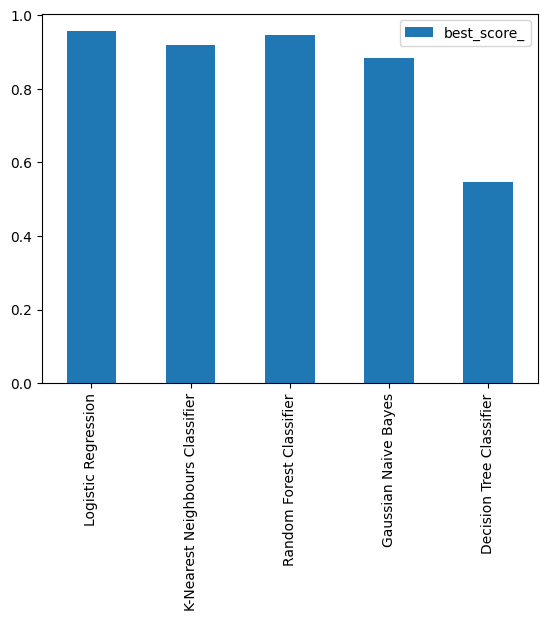

In [18]:
# Recommended Tutorials  
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.bar.html

ax = model_compare.T.plot.bar(stacked=True)
# model_compare.T.plot(kind='bar')